In [1]:
#BioComp Project:
    #We started this project with the goal to work a social distancing method (e.g., "lock down") on an infected population.
#This simulation would show 90% of our population stop moving after a certian number of runs and the remaining 10% would 
#move with a signifcantly reduced speed. We also considered testing the size of the population to a potential difference in
#results before cutting the idea to focus on speed of infection. To accomplish this goal, we decided to use the deer diffusion
#model/deer cabbage procreate model. Since we wanted to show how much "slower" the spread of coronavirus would be when most 
#of our population isn't moving, or at a reduced speed, we started off with one infected dot within it's community. Within 
#the model, we set all parameters but one are set at sensible values. We developed our enclosure to be square, with "closed"
#borders (with walls and corners) instead of toroidal borders, and the arena size of 4.

In [12]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time

In [13]:
# Define constants
class Const: # Carefree remote-eating cheaters
    def __init__(self):
        self.n_animals_max = 300
        self.n_animals_start = 300 # Original n_animals
        self.n_steps = 1000
        self.n_steps_quarentine = 200
        self.vmin = 0.01
        self.qmin = 0.001
        self.vmax = 5*self.vmin
        self.v_decay = 0.7
        self.arena_size = 4
        #self.hp_baby = 20
        #self.hp_reproduction = 35
        #self.hp_birthcost = 30        
        #self.hp_leak = 0.5
        self.contagion_distance = 0.01**1  
        #self.speed= 0.6

In [14]:
# Build the control model (no social distancing implemented)

def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, c.n_steps_quarentine, n_trials))

    for i_trial in range(n_trials):
        # Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(
            #low=c.hp_baby, high=c.hp_reproduction, size=c.n_animals_start)
        
        x = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        y = np.random.uniform(low=0, high=c.arena_size, size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        infected = np.zeros(c.n_animals_max)
        infected[0] = 1 #Patient zero 
    
    
        n_animals = np.zeros(c.n_steps)

        if show_dotses: # Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots; just creating axes
            plt.xlim((0,c.arena_size));
            plt.ylim((0,c.arena_size));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            # Make them run around (keeps speed somewhat randomized)
            
            # Reflect from the walls
            vx = np.where(np.logical_or(x>c.arena_size, x<0), -vx , vx)
            vy = np.where(np.logical_or(y>c.arena_size, y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x, c.arena_size)) # Keep them in enclosure
            y = np.maximum(0,np.minimum(y, c.arena_size))
            
            for i_animal in range(c.n_animals_max):
                if infected[i_animal]==1:
                    d = np.square(x-x[i_animal]) + np.square(y-y[i_animal])
                    victims = np.argwhere(d < c.contagion_distance)
                    infected[victims] = 1
            
            potential_babies = np.argwhere(hp<=0)
            baby_counter = 0
            for i_animal in np.argwhere(hp>0): # <---- This gains about a second of performance                    
        
                if hp[i_animal]>=c.hp_reproduction: # <---------- Healthy enough to have a baby
                    hp[i_animal] -= c.hp_birthcost                 
                    if baby_counter < len(potential_babies): # There are still baby-slots on the list
                        ind = potential_babies[baby_counter] # Shortcut
                        baby_counter += 1                    # Count the baby
                        hp[ind] = c.hp_baby
                        x[ind] = x[i_animal]
                        y[ind] = y[i_animal]
                        vx[ind] = vx[i_animal]
                        vy[ind] = vy[i_animal]
           
            n_animals[t] = np.sum(hp>0)
            
            if show_dotses: # Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=2);
                plt.plot(x[infected==0],y[infected==0],'k.', markersize=2)
                plt.plot(x[infected==1],y[infected==1],'r.', markersize=2)
                plt.xlim((0,c.arena_size))
                plt.ylim((0,c.arena_size));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)
            else:
                print('.',end='')
        # --- Time loop is over

        #history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

SyntaxError: invalid syntax (<ipython-input-14-bc1ae767dafe>, line 12)

In [11]:
c = Const()
np.random.seed(1)
%time curve = model(c, show_dotses=True);

AttributeError: 'Const' object has no attribute 'hp_baby'

In [6]:
# Build the experimental model (social distancing methods implemented)

def model(c, show_dotses=False, n_trials=1):
    history = np.zeros((c.n_steps, c.n_steps_quarentine, n_trials))

    for i_trial in range(n_trials):
        # Allocate hp for all animals, but only first few are alive
        hp = np.zeros(c.n_animals_max)
        hp[:c.n_animals_start] = np.random.uniform(size=c.n_animals_start)
        
        x = np.random.uniform(low=0, high=c.arena_size,size=c.n_animals_max)
        y = np.random.uniform(low=0, high=c.arena_size,size=c.n_animals_max)
        vx = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        vy = np.random.uniform(size=c.n_animals_max, low=c.vmin, high=c.vmax)*(
            2*np.random.randint(size=c.n_animals_max,low=0,high=2) - 1)
        infected = np.zeros(c.n_animals_max)
        infected[0] = 1 #Patient zero 
    
    
        n_animals = np.zeros(c.n_steps)

        if show_dotses: # Init plots
            fig = plt.figure(figsize=(3,3))
            ax = plt.subplot(111) # No subplots; just creating axes
            plt.xlim((0,c.arena_size));
            plt.ylim((0,c.arena_size));
            fig.show()
            fig.canvas.draw()

        for t in range(c.n_steps):
            x += vx
            y += vy
            
            vx = vx*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin 
            vy = vy*c.v_decay + np.random.randn(c.n_animals_max)*c.vmin
            
            if (t) > 150:
                c.vmin = 0.001
            # Make them run around (keeps speed somewhat randomized)
            
            #reduce speed of deer after 150 steps
            #if (c.n_steps) > 150:
            #    x += vx
             #   y += vy
                
            #    vx = np.random.randn(c.n_animals_max)*0.001
            #    vy = np.random.randn(c.n_animals_max)*0.001
           
            #if infected[victims]>50:    -----# This didnt work within the same loop or in diff one= Good try tho!
                #self.speed= 0
                
            # Reflect from the walls
            vx = np.where(np.logical_or(x>c.arena_size, x<0), -vx , vx)
            vy = np.where(np.logical_or(y>c.arena_size, y<0), -vy , vy)
            x = np.maximum(0,np.minimum(x, c.arena_size)) # Keep them in enclosure
            y = np.maximum(0,np.minimum(y, c.arena_size))
            
            for i_animal in range(c.n_animals_max):
                if infected[i_animal]==1:
                    d = np.square(x-x[i_animal]) + np.square(y-y[i_animal])
                    victims = np.argwhere(d < c.contagion_distance)
                    infected[victims] = 1
            
            potential_babies = np.argwhere(hp<=0)
            baby_counter = 0
            for i_animal in np.argwhere(hp>0): # <---- This gains about a second of performance                    
        

           
                n_animals[t] = np.sum(hp>0)
            
            if show_dotses: # Actual animation
                ax.clear()
                plt.plot(x[hp>0], y[hp>0], 'k.',markersize=4);
                plt.plot(x[infected==0],y[infected==0],'k.', markersize=4)
                plt.plot(x[infected==1],y[infected==1],'r.', markersize=4)
                plt.xlim((0,c.arena_size))
                plt.ylim((0,c.arena_size));
                fig.canvas.draw() # Redraws the canvas (key secret command to animate things)

            else:
                print('.',end='')
        # --- Time loop is over

        #history[:,i_trial] = n_animals
    return np.mean(history, axis=1)

<IPython.core.display.Javascript object>


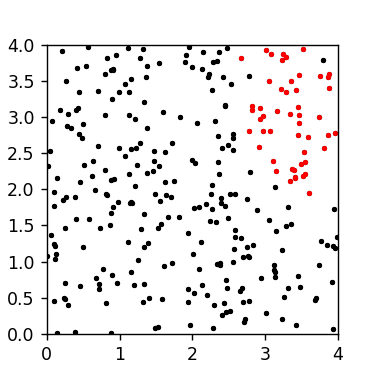

Wall time: 58.1 s


In [7]:
c = Const()
np.random.seed(1)
%time curve = model(c, show_dotses=True);

In [8]:
    #We ultimately could not figure out how to seperate the population unitl two groups. Becuase of this, we focused on 
#stopping the motion of the dots within their population. the speed. Since we wanted to show how much "slower" (i.e., 0 
#speed). We started off with one infected dot within it's community. Within the model, we set all parameters but one are 
#set at sensible values. To influence the speed, we changed the value of two of our parameters. We added a conditional
#statement inside the loop that changed the vmin value of 0.01 to 0.005 and the v_decay value of 0.7 to a 0.001 after a set 
#number of runs. It worked! We also tried to add another statement to stop all motion of individuals after a set number of 
#them were infected, which did not achieve as successful results as the other attempt. In the end, the rate of infected was 
#reduced. Visualy, the majority of the control group population was infected. In the experimental group, less than 1/4 of 
#the population was infected was infected by the end of the simulation. 